# Surface IV à partir des données Basket/data

Ce notebook charge les fichiers CSV disponibles dans `Basket/data/` (`train.csv`, `test.csv`),
construit une grille régulière `(K, T)` à partir des colonnes `Strikes`, `Maturity` et `Volatility`,
puis trace la surface de volatilité implicite (3D + heatmap 2D).


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401, active projection='3d'


In [15]:
DATA_DIR = Path("/home/salok1/RepoFinal/Basket/data")
if not DATA_DIR.exists():
    raise FileNotFoundError(f"Répertoire introuvable: {DATA_DIR}")
DATA_DIR


PosixPath('/home/salok1/RepoFinal/Basket/data')

In [16]:
def build_grid(
    df: pd.DataFrame,
    S0: float,
    n_K: int = 200,
    n_T: int = 200,
    K_min: float | None = None,
    K_max: float | None = None,
    T_min: float | None = None,
    T_max: float | None = None,
    K_span: float | None = None,
    margin_frac: float = 0.02,
):
    """Construit une grille régulière (K, T) et moyenne les IV dans chaque cellule.

    - Si `K_min/K_max` ne sont pas fournis, on les déduit des données avec une marge.
    - Sinon, on peut forcer une fenêtre symétrique via `K_span` autour de `S0`.
    - Les bornes en maturité sont par défaut celles du dataset.
    """

    if K_min is None or K_max is None:
        if K_span is not None:
            K_min = S0 - K_span
            K_max = S0 + K_span
        else:
            data_K_min = float(df["K"].min())
            data_K_max = float(df["K"].max())
            delta_K = data_K_max - data_K_min
            pad = delta_K * margin_frac
            K_min = data_K_min - pad
            K_max = data_K_max + pad

    if T_min is None:
        T_min = float(df["T"].min())
    if T_max is None:
        T_max = float(df["T"].max())

    if K_min >= K_max:
        raise ValueError("K_min doit être inférieur à K_max.")
    if T_min >= T_max:
        raise ValueError("T_min doit être inférieur à T_max.")

    K_vals = np.linspace(K_min, K_max, n_K)
    T_vals = np.linspace(T_min, T_max, n_T)

    df = df[(df["K"] >= K_min) & (df["K"] <= K_max)].copy()
    df = df[(df["T"] >= T_min) & (df["T"] <= T_max)]

    if df.empty:
        raise ValueError("Aucun point n'appartient au domaine défini par la grille.")

    df["K_idx"] = np.searchsorted(K_vals, df["K"], side="left").clip(0, n_K - 1)
    df["T_idx"] = np.searchsorted(T_vals, df["T"], side="left").clip(0, n_T - 1)

    grouped = df.groupby(["T_idx", "K_idx"])["iv"].mean().reset_index()

    iv_grid = np.full((n_T, n_K), np.nan, dtype=float)
    for _, row in grouped.iterrows():
        iv_grid[int(row["T_idx"]), int(row["K_idx"])] = row["iv"]

    K_grid, T_grid = np.meshgrid(K_vals, T_vals)
    return K_grid, T_grid, iv_grid


In [17]:
def plot_surface(K_grid, T_grid, iv_grid, title_suffix=""):
    """Affiche surface 3D + heatmap 2D de la volatilité implicite."""
    fig = plt.figure(figsize=(12, 5))

    ax3d = fig.add_subplot(1, 2, 1, projection="3d")
    iv_flat = iv_grid[~np.isnan(iv_grid)]
    if iv_flat.size == 0:
        raise ValueError("La grille IV est entièrement vide.")
    iv_mean = iv_flat.mean()
    iv_fill = np.where(np.isnan(iv_grid), iv_mean, iv_grid)

    surf = ax3d.plot_surface(
        K_grid,
        T_grid,
        iv_fill,
        rstride=1,
        cstride=1,
        linewidth=0.2,
        antialiased=True,
        cmap="viridis",
    )
    ax3d.set_xlabel("Strike K")
    ax3d.set_ylabel("Maturité T (années)")
    ax3d.set_zlabel("Implied vol")
    ax3d.set_title(f"Surface IV 3D{title_suffix}")
    fig.colorbar(surf, ax=ax3d, shrink=0.6, aspect=10, label="iv")

    ax2d = fig.add_subplot(1, 2, 2)
    im = ax2d.imshow(
        iv_fill,
        extent=[K_grid.min(), K_grid.max(), T_grid.min(), T_grid.max()],
        origin="lower",
        aspect="auto",
        cmap="viridis",
    )
    ax2d.set_xlabel("Strike K")
    ax2d.set_ylabel("Maturité T (années)")
    ax2d.set_title(f"Heatmap IV{title_suffix}")
    fig.colorbar(im, ax=ax2d, label="iv")

    plt.tight_layout()
    plt.show()


In [18]:
def load_iv_dataframe(csv_path: Path):
    """Charge un CSV Basket/data et renvoie (df_iv, S0_estime)."""
    df = pd.read_csv(csv_path)
    required_cols = {"Strikes", "Maturity", "Volatility"}
    if not required_cols.issubset(df.columns):
        raise ValueError(f"Colonnes manquantes: {required_cols - set(df.columns)}")

    df_iv = pd.DataFrame({
        "K": df["Strikes"],
        "T": df["Maturity"],
        "iv": df["Volatility"],
    })

    if "Prices" in df.columns:
        S0 = float(df["Prices"].mean())
    elif "S/K" in df.columns and "Strikes" in df.columns:
        S0 = float((df["S/K"] * df["Strikes"]).mean())
    else:
        S0 = float(df["Strikes"].mean())

    return df_iv, S0


In [19]:
train_path = DATA_DIR / "train.csv"
train_df, S0_train = load_iv_dataframe(train_path)
print(f"Train → {len(train_df)} points, S0 moyen ~ {S0_train:.2f}")
train_df.describe().T


Train → 7000 points, S0 moyen ~ 99.98


,count,mean,std,min,25%,50%,75%,max
K,7000.0,200.006679,0.991482,196.567458,199.339685,199.988474,200.668035,203.743188
T,7000.0,0.646174,0.261018,0.200292,0.418780,0.641253,0.875366,1.099885
iv,7000.0,0.504687,0.285268,0.010083,0.257507,0.501178,0.752713,0.999862


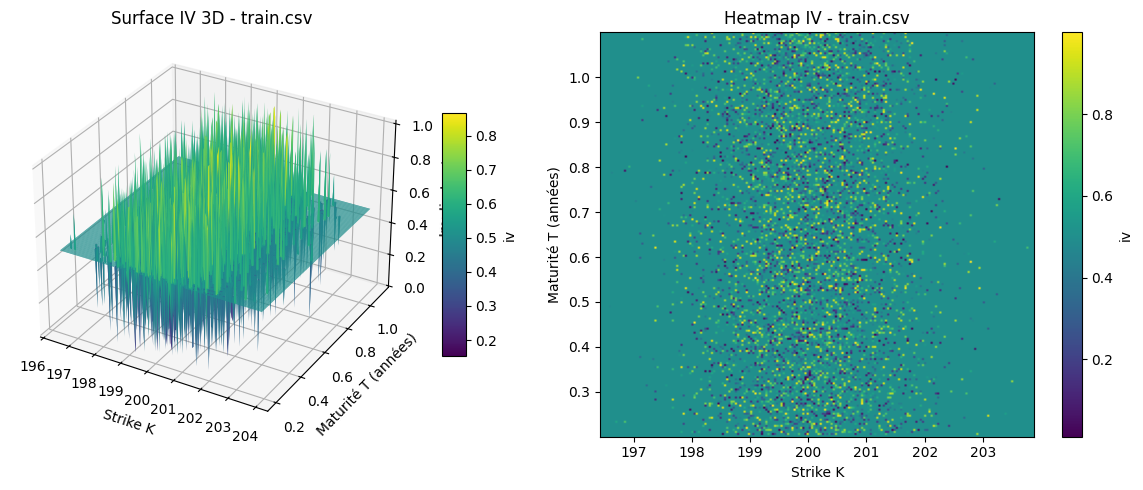

In [20]:
K_grid_train, T_grid_train, iv_grid_train = build_grid(
    train_df,
    S0=S0_train,
    n_K=200,
    n_T=200,
)
plot_surface(K_grid_train, T_grid_train, iv_grid_train, title_suffix=" - train.csv")


In [21]:
test_path = DATA_DIR / "test.csv"
test_df, S0_test = load_iv_dataframe(test_path)
print(f"Test → {len(test_df)} points, S0 moyen ~ {S0_test:.2f}")
test_df.describe().T


Test → 3000 points, S0 moyen ~ 99.99


,count,mean,std,min,25%,50%,75%,max
K,3000.0,199.983343,1.015930,196.506789,199.324427,199.974860,200.682903,203.620546
T,3000.0,0.643045,0.262342,0.200168,0.410948,0.645653,0.874088,1.099737
iv,3000.0,0.494183,0.287813,0.010287,0.239373,0.495917,0.744223,0.999496


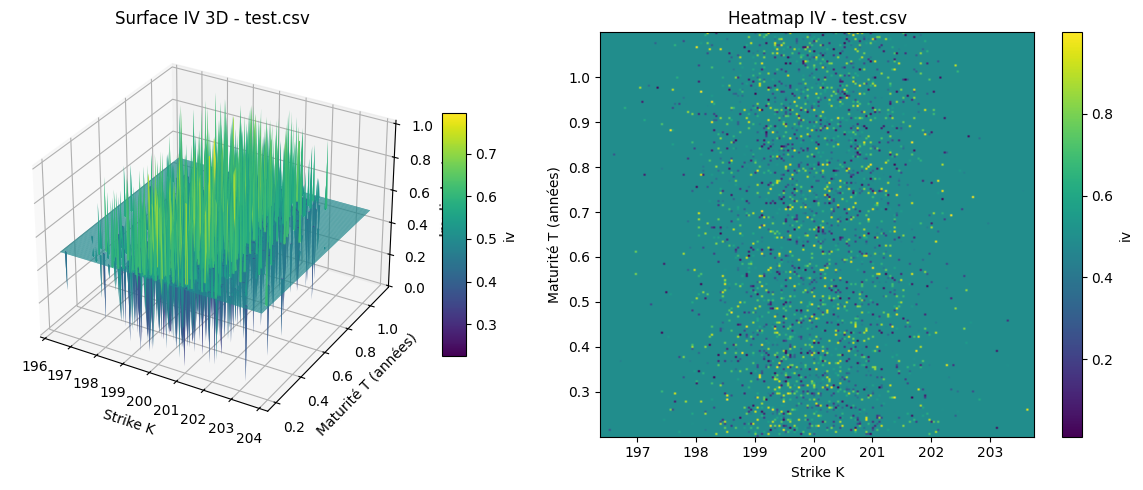

In [22]:
K_grid_test, T_grid_test, iv_grid_test = build_grid(
    test_df,
    S0=S0_test,
    n_K=200,
    n_T=200,
)
plot_surface(K_grid_test, T_grid_test, iv_grid_test, title_suffix=" - test.csv")
